# Reproduce SIREN on high resolution image

## Import dependencies

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time
from collections import OrderedDict

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    # tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    if isinstance(sidelen, int):  # If sidelen is a single integer
        tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    elif isinstance(sidelen, tuple):  # If sidelen is a tuple of dimensions
        tensors = [torch.linspace(-1, 1, steps=s) for s in sidelen]
    else:
        raise TypeError("sidelen must be an int or tuple of ints.")
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

## Design activation function and model


In [6]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [2]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

## Load the image

In [3]:
def get_tensor(image, sidelength):
    # img = Image.fromarray(skimage.data.camera())
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(image)
    return img


Fitting image

In [4]:
class ImageFitting(Dataset):
    def __init__(self, image, sidelength):
        super().__init__()

        if isinstance(sidelength, int):
            self.coords = get_mgrid(sidelength, dim=2)
        elif isinstance(sidelength, tuple):
            self.coords = get_mgrid(sidelength, dim=len(sidelength))
        else:
            raise ValueError("sidelength must be an int or tuple of ints.")

        img = get_tensor(image, sidelength)

        # self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.pixels = img.permute(1, 2, 0).reshape(-1, 1)
        # Prepare pixels (flattened RGB values)
        # self.pixels = img.permute(1, 2, 0).contiguous().view(-1, img.size(0))  # RGB = 3 channels

        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixels

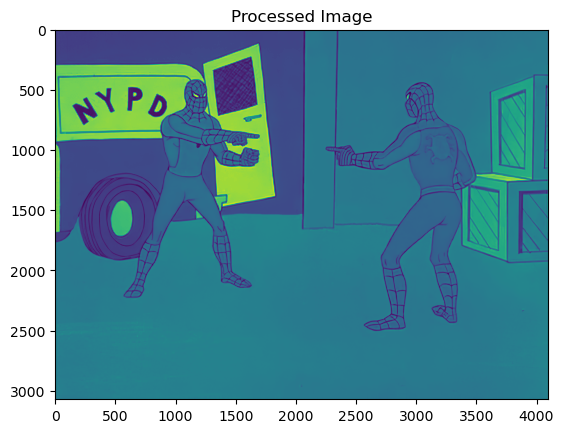

/opt/homebrew/Caskroom/miniforge/base/envs/DP/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1730862381898/work/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
# image = Image.open('heyayayaya.jpg')
image = Image.open('spiderman.jpg')

# Convert the image to grey scale or the dimension of the image would be too big to train
image = image.convert("L")

plt.imshow(image)
plt.title("Processed Image")
plt.show()

# Define the dimension of the image
imgx = 256
imgy = 256

heyayaya = ImageFitting(image, (imgx, imgy))
dataloader = DataLoader(heyayaya, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

In [6]:
heyayaya.pixels.shape

torch.Size([65536, 1])

In [9]:
# torch.cuda.empty_cache()

Fit SIREN in training loop

In [23]:
# Define parameters for training loop
total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 50

Step 0, Total loss 0.010689


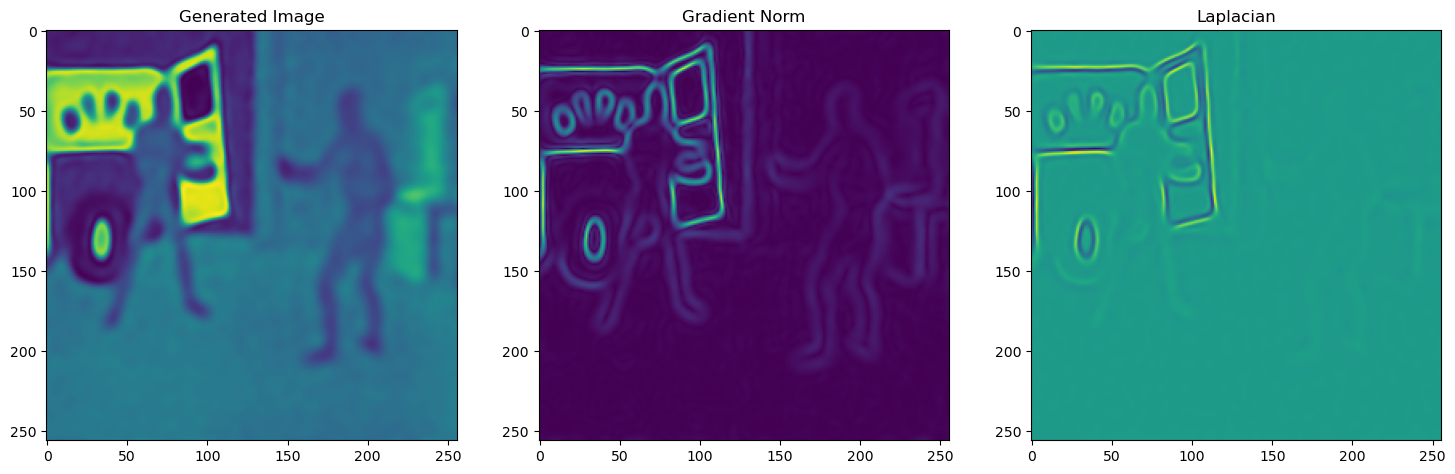

Step 25, Total loss 0.008277


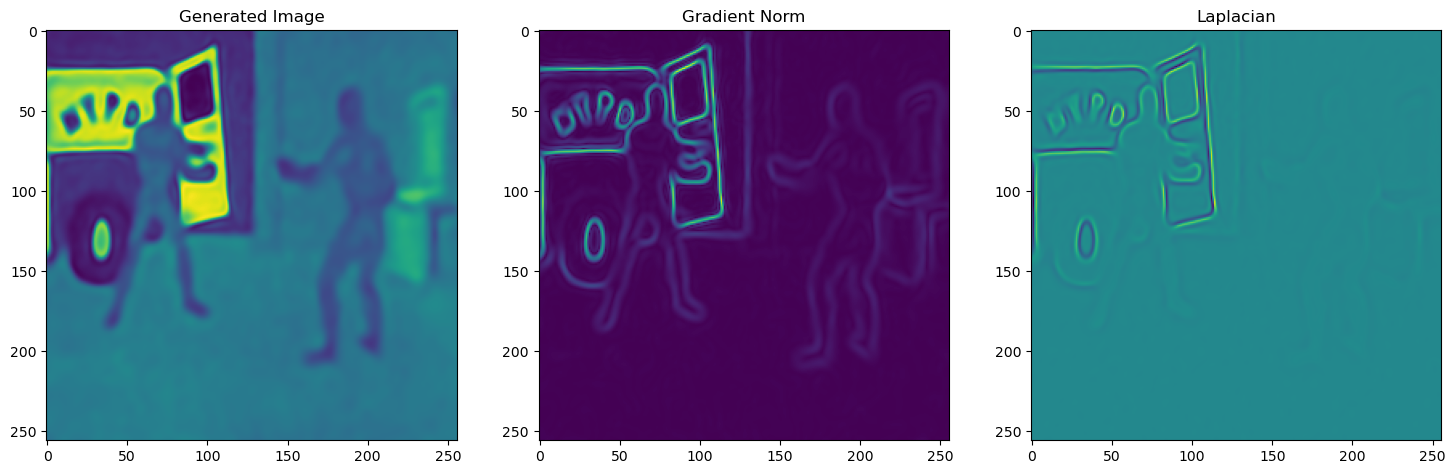

Step 50, Total loss 0.006114


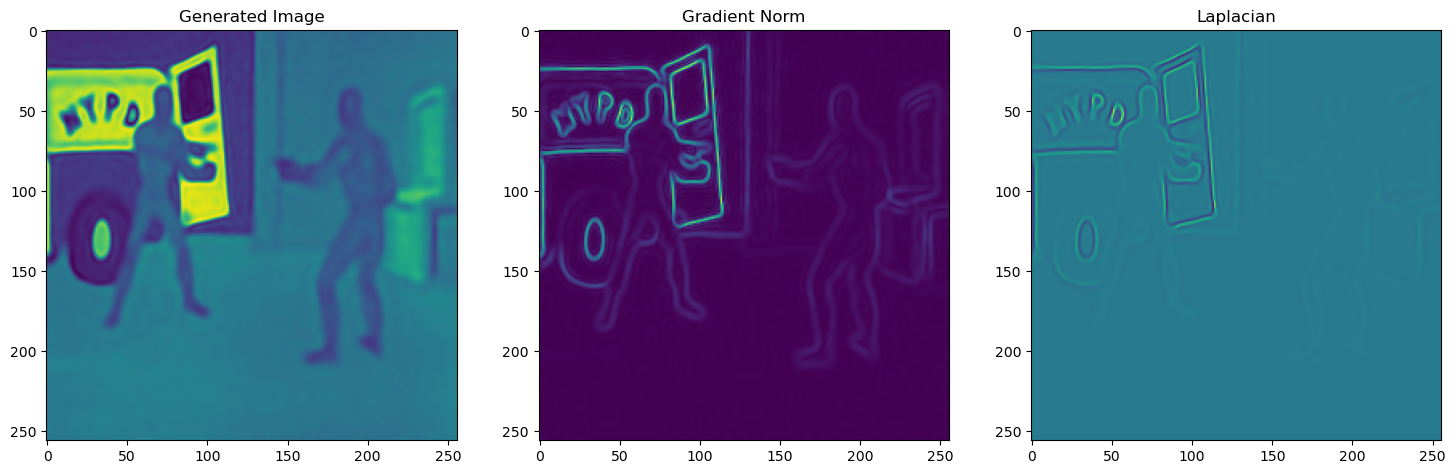

In [ ]:
optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
# model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

training_loss = []

for step in range(total_steps+1):
    model_output, coords = img_siren(model_input)
    loss = ((model_output - ground_truth)**2).mean()


    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        img_grad = gradient(model_output, coords)
        img_laplacian = laplace(model_output, coords)

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(model_output.cpu().view(imgx,imgy).detach().numpy())
        axes[0].set_title("Generated Image")
        axes[1].imshow(img_grad.norm(dim=-1).cpu().view(imgx,imgy).detach().numpy())
        axes[1].set_title("Gradient Norm")
        axes[2].imshow(img_laplacian.cpu().view(imgx,imgy).detach().numpy())
        axes[2].set_title("Laplacian")
        plt.show()
        # plt.savefig(f"{step}th_generated_plot.png")
        # plt.close(fig)  # Close figure to save memory



    optim.zero_grad()
    loss.backward()
    optim.step()

    training_loss.append(loss.item())

    # torch.cuda.empty_cache()

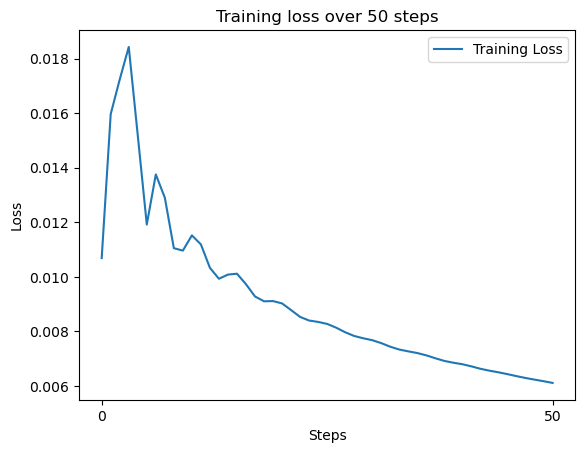

In [17]:
plt.plot(training_loss, label="Training Loss")
plt.title(f"Training loss over {total_steps} steps")
plt.xticks(range(0, total_steps+1, 50))
plt.xlabel("Steps", )
plt.ylabel("Loss")
plt.legend()
plt.show()

# Design my Activation Function (periodic function)

Import my own activation function and model

In [10]:
from CREN import Cren
from CustomAct import custom_activation

In [30]:
def smooth_square_wave(x, sharpness=10):
    return torch.tanh(sharpness * torch.sin(x))

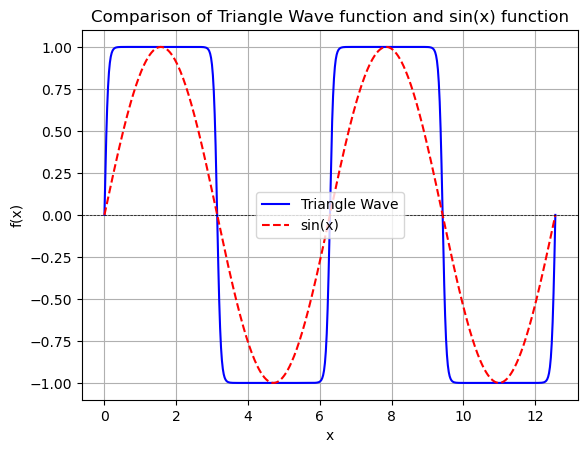

In [8]:
# Generate input data
x = torch.linspace(0, 4 * np.pi, 500)  # Input range from 0 to 4π

# Compute the triangle wave
# y_triangle = triangle_wave(x)
# y_triangle = smooth_square_wave(x)
y_triangle = custom_activation(x)


# Compute the sine wave for comparison
y_sine = torch.sin(x)

# Plot both waves
plt.plot(x.numpy(), y_triangle.numpy(), label="Triangle Wave", color="blue")
plt.plot(x.numpy(), y_sine.numpy(), label="sin(x)", linestyle="--", color="red")
plt.title("Comparison of Triangle Wave function and sin(x) function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.legend()
plt.grid()
plt.show()




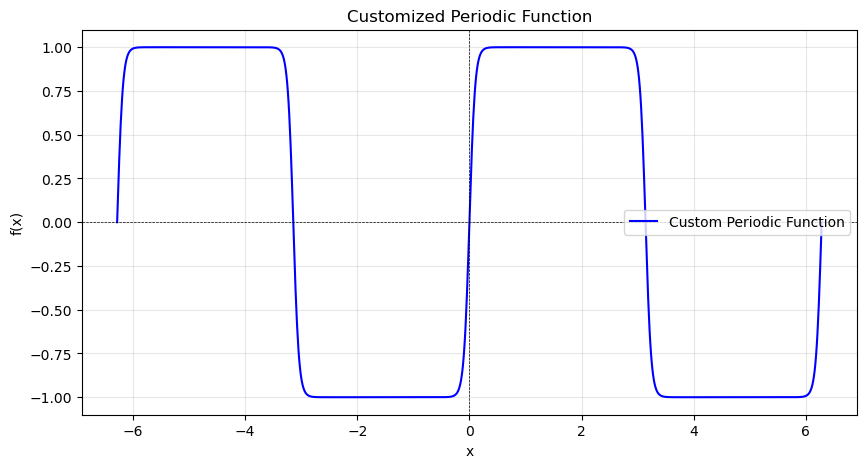

In [9]:
# Generate x values (input range for the function)
x = np.linspace(-2 * np.pi, 2 * np.pi, 1000)  # Covers two periods of sine

# Convert x to a PyTorch tensor
x_tensor = torch.tensor(x, dtype=torch.float32)

# Evaluate your function for the x values
y_tensor = custom_activation(x_tensor)

# Convert the result back to NumPy for plotting
y = y_tensor.numpy()

# Plot the function
plt.figure(figsize=(10, 5))
plt.plot(x, y, label="Custom Periodic Function", color="blue")
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Add a horizontal line at y=0
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')  # Add a vertical line at x=0
plt.title("Customized Periodic Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Implement the model

In [12]:
img_sqren = Cren(in_features=2, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)

Training loop for my model

In [11]:
# Define parameters for training loop
total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 100

Step 0, Total loss 0.106956


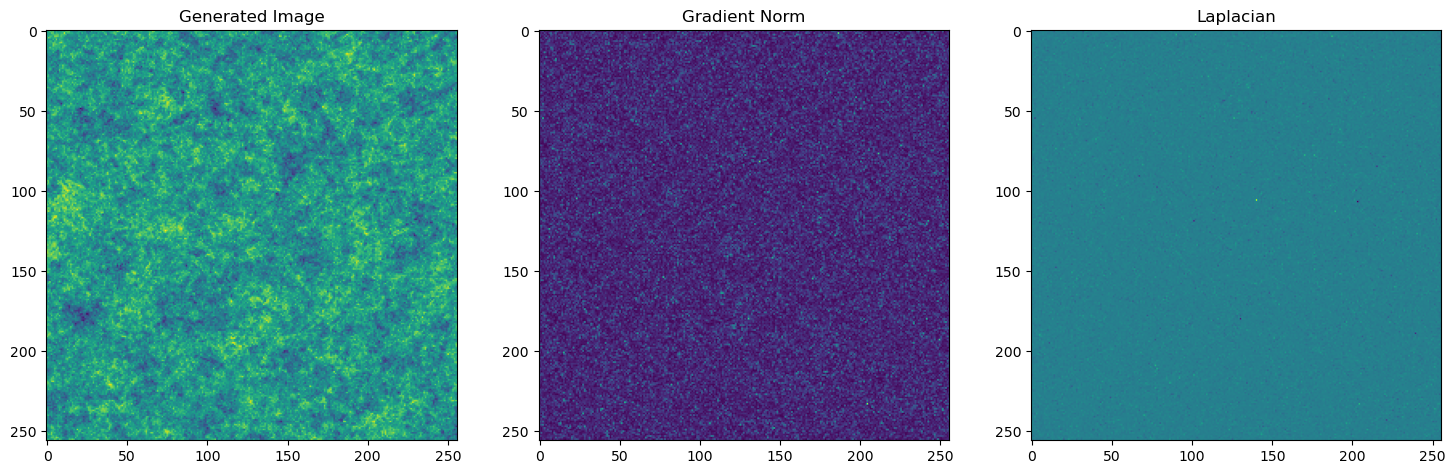

Step 100, Total loss 0.000359


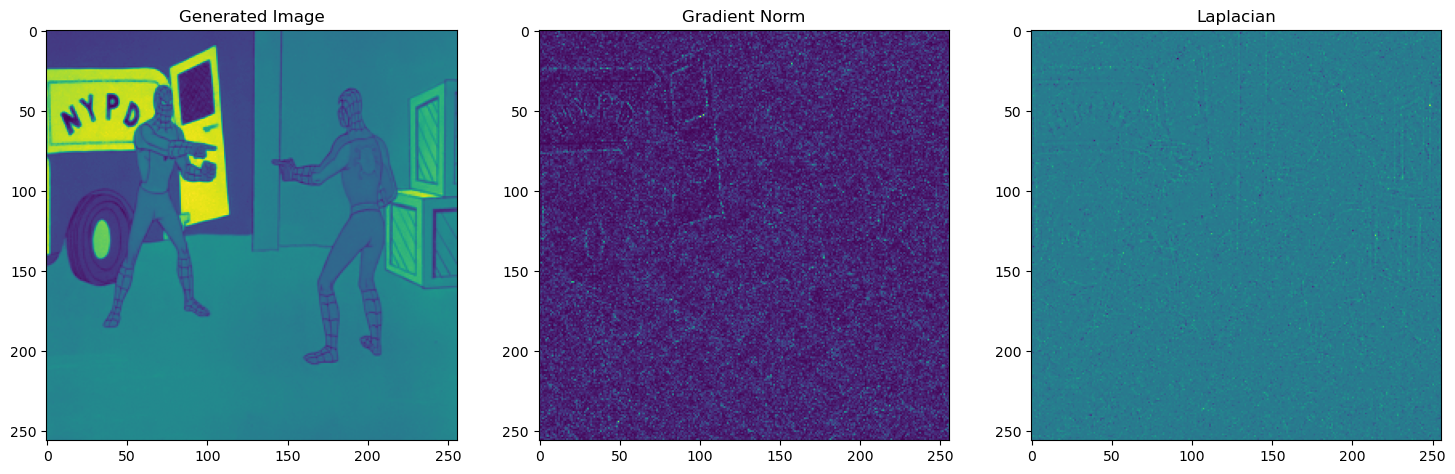

Step 200, Total loss 0.000107


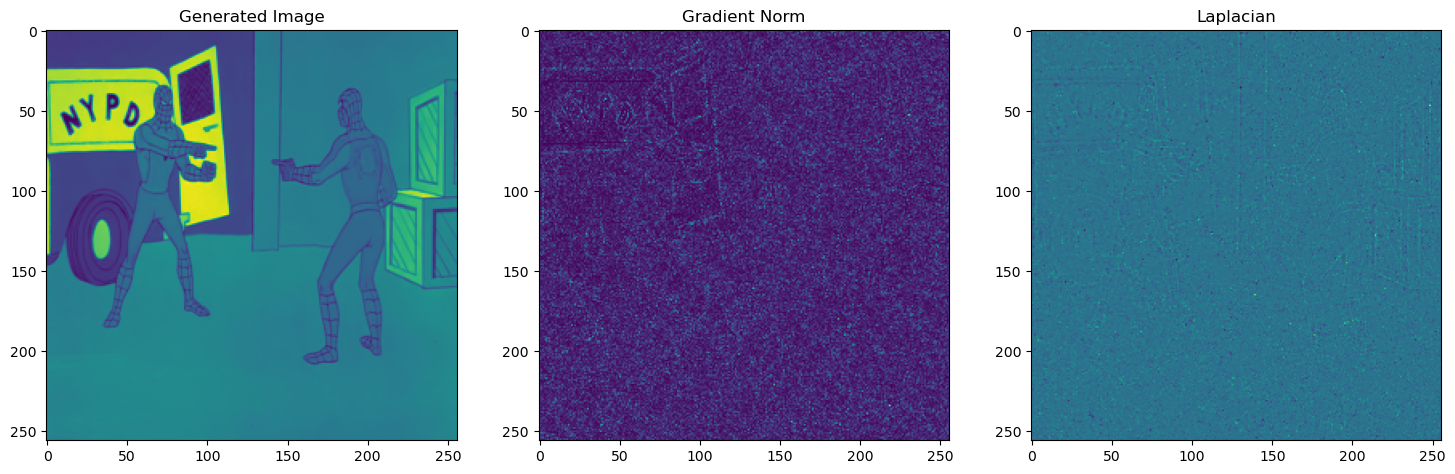

Step 300, Total loss 0.000053


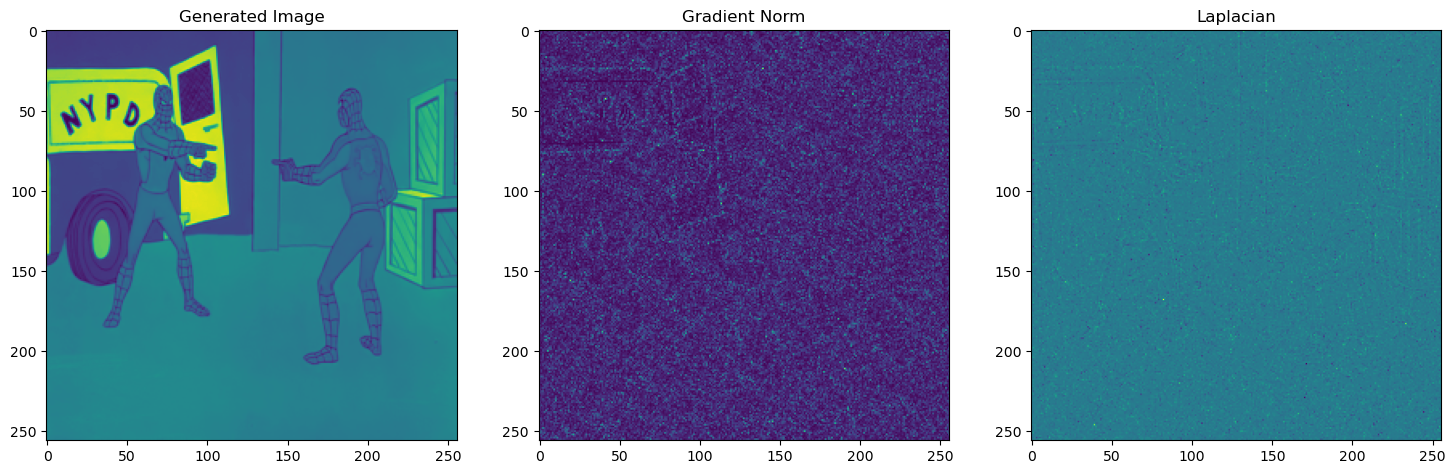

KeyboardInterrupt: 

In [13]:
optim = torch.optim.Adam(lr=1e-4, params=img_sqren.parameters())

model_input, ground_truth = next(iter(dataloader))
# model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

training_loss = []

for step in range(total_steps+1):
    model_output, coords = img_sqren(model_input)
    loss = ((model_output - ground_truth)**2).mean()


    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        img_grad = gradient(model_output, coords)
        img_laplacian = laplace(model_output, coords)

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(model_output.cpu().view(imgx,imgy).detach().numpy())
        axes[0].set_title("Generated Image")
        axes[1].imshow(img_grad.norm(dim=-1).cpu().view(imgx,imgy).detach().numpy())
        axes[1].set_title("Gradient Norm")
        axes[2].imshow(img_laplacian.cpu().view(imgx,imgy).detach().numpy())
        axes[2].set_title("Laplacian")
        plt.show()
        # plt.savefig(f"{step}th_generated_plot.png")
        # plt.close(fig)  # Close figure to save memory



    optim.zero_grad()
    loss.backward()
    optim.step()

    training_loss.append(loss.item())

    # torch.cuda.empty_cache()

Training loss for my model

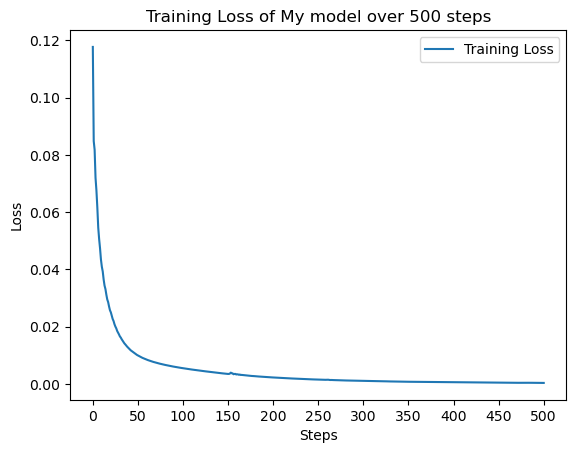

In [56]:
plt.plot(training_loss, label="Training Loss")
plt.title(f"Training Loss of My model over {total_steps} steps")
plt.xticks(range(0, total_steps+1, 50))
plt.xlabel("Steps", )
plt.ylabel("Loss")
plt.legend()
plt.show()